In [31]:
import pandas as pd
import numpy as np
import torch
from preprocessing.feature_engineering import FeatureEngineering
from preprocessing.Resampling import Resampling
from graph.graph_construction import GraphConstruction
from models.GNNs import GraphSAGE2
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import to_hetero
from torch_geometric.loader import HGTLoader
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import tqdm

In [28]:
dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/original_dataset.csv')

# Apply feature engineering on the dataset
fe = FeatureEngineering(dataset)
processed_dataset = fe.apply_feature_engineering()

# Apply resampling on the dataset
resampler = Resampling(processed_dataset, test_size=0.4, random_state=42)
final_dataset = resampler.apply_resampling()

Feature engineering completed.
Fraud rate in training set before resampling: 0.54%
Fraud rate in testing set: 0.62%
Fraud rate in training set after resampling: 50.00%
Fraud rate in testing set after resampling: 0.62%
Length of training set: 953192
Length of testing set: 198889


In [29]:
final_dataset.head()
final_dataset.to_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv', index=False)

In [22]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [23]:
final_dataset = pd.read_csv('C:/Users/ruben/OneDrive/Desktop/Datasets/final_dataset.csv')

# Percentage in Test and Val set is not the same because there is no stratified split performed
graph_constructor = GraphConstruction(final_dataset)
data = graph_constructor.apply_graph_construction()

Fraud Percentage in Train Mask: 50.00%
Fraud Percentage in Test Mask: 0.61%
Fraud Percentage in Val Mask: 0.63%
Graph Construction Successful!


In [24]:
model = GraphSAGE2(hidden_dim=64, embedding_dim=64, output_dim=1, num_layers=2, dropout_rate=0.5, sage_aggr='mean')
model = to_hetero(model, data.metadata(), aggr='sum')
data, model = data.to(device), model.to(device)

optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\nn\to_hetero_transformer.py:165: UserWarning: The type 'rev_received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [25]:
train_size = data['transaction'].train_mask.sum().item()
val_size = data['transaction'].val_mask.sum().item()
test_size = data['transaction'].test_mask.sum().item()

train_loader = HGTLoader(
    data, num_samples={key: [train_size] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].train_mask), 
    batch_size=train_size, num_workers=6, persistent_workers=True)

val_loader = HGTLoader(
    data, num_samples={key: [val_size] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].val_mask), 
    batch_size=val_size, num_workers=6, persistent_workers=True)

test_loader = HGTLoader(
    data, num_samples={key: [test_size] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].test_mask), 
    batch_size=test_size, num_workers=6, persistent_workers=True)

In [26]:
@torch.no_grad()
def init_params():
    batch = next(iter(train_loader))
    batch = batch.to(device, 'edge_index')
    model(batch.x_dict, batch.edge_index_dict)

In [27]:
def train():
    model.train()
    optimizer.zero_grad()
    
    # Process the entire training set as a single batch
    for batch in tqdm(train_loader):
        batch = batch.to(device, 'edge_index')
        out = model(batch.x_dict, batch.edge_index_dict)['transaction']
        loss = criterion(out.squeeze(1), batch['transaction'].y.float())
        loss.backward()
    
    optimizer.step()
    scheduler.step()
    return float(loss)

In [28]:
@torch.no_grad()
def test(loader):
    model.eval()
    y_pred_probas = []
    y_trues = []
    
    total_loss = 0

    for batch in tqdm(loader):
        batch = batch.to(device, 'edge_index')
        y = batch['transaction'].y
        y_hat = model(batch.x_dict, batch.edge_index_dict)['transaction']
        loss = criterion(y_hat.squeeze(1), y.float())

        total_loss += float(loss)
        y_pred_probas.append(torch.sigmoid(y_hat.cpu()).numpy())
        y_trues.append(y.cpu().numpy())

    y_true = np.concatenate(y_trues)
    y_pred_proba = np.concatenate(y_pred_probas)

    return y_true, y_pred_proba, total_loss / len(loader)

In [29]:
init_params()

training_losses = []
validation_losses = []

consecutive_increases = 0
max_consecutive_increases = 5

for epoch in range(20):
    loss = train()
    print(f'Epoch {epoch+1:02d}, Training loss: {loss:.4f}')
    training_losses.append(loss)

    y_val, y_val_pred_proba, val_loss = test(val_loader)
    print(f'Epoch {epoch+1:02d}, Validation loss: {val_loss:.4f}')
    validation_losses.append(val_loss)

    ap_val = average_precision_score(y_val, y_val_pred_proba)
    roc_val = roc_auc_score(y_val, y_val_pred_proba)

    print(f'Epoch {epoch+1:02d}, Average precision validation set: {ap_val:.2f}, ROC AUC validation set: {roc_val:.2f}')

    # Check for early stopping
    if epoch > 0 and val_loss >= validation_losses[-2]:
        consecutive_increases += 1
        if consecutive_increases >= max_consecutive_increases:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    else:
        consecutive_increases = 0

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


Epoch 01, Training loss: 0.7008


100%|██████████| 1/1 [00:10<00:00, 10.53s/it]


Epoch 01, Validation loss: 0.6961
Epoch 01, Average precision validation set: 0.01, ROC AUC validation set: 0.58


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 02, Training loss: 0.7013


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 02, Validation loss: 0.6943
Epoch 02, Average precision validation set: 0.01, ROC AUC validation set: 0.59


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Epoch 03, Training loss: 0.7008


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 03, Validation loss: 0.6915
Epoch 03, Average precision validation set: 0.01, ROC AUC validation set: 0.59


100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


Epoch 04, Training loss: 0.6988


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 04, Validation loss: 0.6894
Epoch 04, Average precision validation set: 0.01, ROC AUC validation set: 0.60


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch 05, Training loss: 0.7003


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 05, Validation loss: 0.6878
Epoch 05, Average precision validation set: 0.01, ROC AUC validation set: 0.60


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


Epoch 06, Training loss: 0.6990


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 06, Validation loss: 0.6866
Epoch 06, Average precision validation set: 0.01, ROC AUC validation set: 0.60


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 07, Training loss: 0.7029


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 07, Validation loss: 0.6861
Epoch 07, Average precision validation set: 0.01, ROC AUC validation set: 0.61


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Epoch 08, Training loss: 0.7000


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 08, Validation loss: 0.6859
Epoch 08, Average precision validation set: 0.01, ROC AUC validation set: 0.61


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch 09, Training loss: 0.6976


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 09, Validation loss: 0.6857
Epoch 09, Average precision validation set: 0.01, ROC AUC validation set: 0.61


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Epoch 10, Training loss: 0.6964


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Epoch 10, Validation loss: 0.6856
Epoch 10, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch 11, Training loss: 0.6999


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 11, Validation loss: 0.6855
Epoch 11, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 12, Training loss: 0.6966


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Epoch 12, Validation loss: 0.6855
Epoch 12, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch 13, Training loss: 0.6965


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Epoch 13, Validation loss: 0.6854
Epoch 13, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Epoch 14, Training loss: 0.6982


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 14, Validation loss: 0.6853
Epoch 14, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 15, Training loss: 0.6970


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Epoch 15, Validation loss: 0.6853
Epoch 15, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Epoch 16, Training loss: 0.6985


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Epoch 16, Validation loss: 0.6853
Epoch 16, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch 17, Training loss: 0.6996


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 17, Validation loss: 0.6853
Epoch 17, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Epoch 18, Training loss: 0.6984


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 18, Validation loss: 0.6854
Epoch 18, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch 19, Training loss: 0.6973


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 19, Validation loss: 0.6854
Epoch 19, Average precision validation set: 0.01, ROC AUC validation set: 0.62


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Epoch 20, Training loss: 0.6990


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

Epoch 20, Validation loss: 0.6855
Epoch 20, Average precision validation set: 0.01, ROC AUC validation set: 0.62


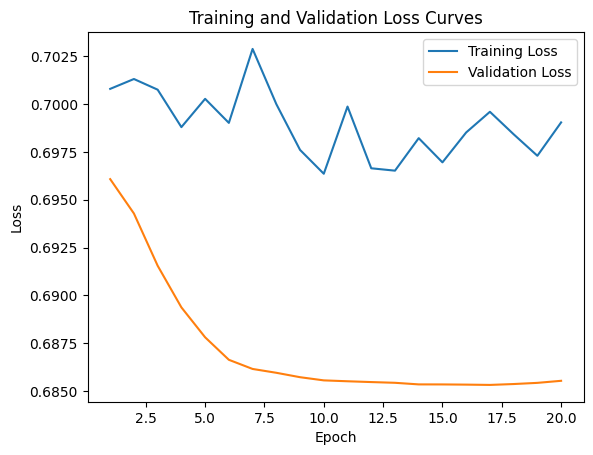

In [30]:
plt.figure()
plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

In [24]:
# Evaluate the model on the test set
y_test, y_test_pred_proba, test_loss = test(data['transaction'].test_mask)
ap_test = average_precision_score(y_test, y_test_pred_proba)
roc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Average precision testing set: {ap_test:.4f}, ROC AUC testing set: {roc_test:.4f}')

Average precision testing set: 0.0676, ROC AUC testing set: 0.7751
